# Limpieza y preparación de datos para análisis de sentimientos

In [ ]:
!pip install umap-learn
!pip install hdbscan
!pip install utils
!pip install emoji

  Using cached emoji-2.11.1-py2.py3-none-any.whl (433 kB)


In [ ]:
import numpy as np
import pandas as pd
import random as rn
import re
import nltk
import os
import emoji

import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from nltk.corpus import stopwords
from wordcloud import WordCloud





In [ ]:
import umap # dimensionality reduction
import hdbscan # clustering
from functools import partial

# To perform the Bayesian Optimization for searching the optimum hyperparameters,
# we use hyperopt package:
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

import collections
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

import utils

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Conexión con mi unidad en Google Drive

Mounted at /content/drive


Una función lambda en Python es una pequeña función anónima que puede tener cualquier número de argumentos pero sólo una expresión. Se utilizan a menudo cuando se necesita una función corta para un corto período de tiempo, a menudo como argumento de funciones de orden superior (funciones que toman otras funciones como argumentos)

In [ ]:
rn.seed(a=42)

p = 0.004  # to randomly select 0.4% of the rows

df_reviews = pd.read_csv('/content/drive/MyDrive/Aprendizaje no supervisado/Aprendizaje-No-Supervisado-para-AD-2024-1/Clase13/steam.csv', skiprows=lambda i: i>0 and rn.random() > p, names=['app_id', 'review_text', 'review_score', 'review_votes'])

# size of dataframe
print(df_reviews.shape)
# display the head of data
display(df_reviews.head())


(25436, 4)


,app_id,review_text,review_score,review_votes
0,10,Ruined my life.,1,0
1,10,Think you got skills because you came from CS:...,1,1
2,10,(I've deleted all the comments on this because...,1,0
3,10,Game will be played forever,1,0
4,10,i can't stop playing :D,1,0


<ipython-input-10-31fa4152d582>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'review_score', data = df_reviews, palette=['red', 'green'])


<Axes: xlabel='review_score', ylabel='count'>

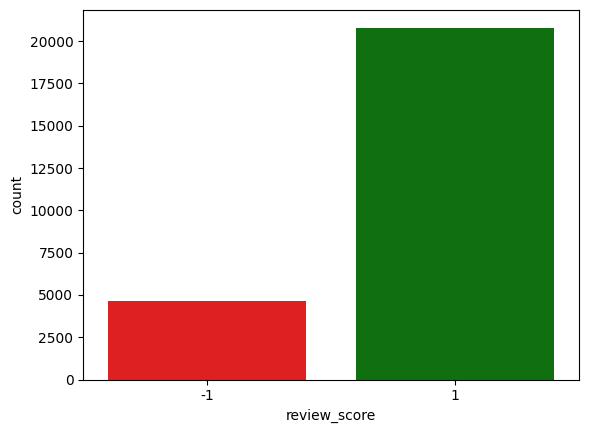

In [ ]:
sns.countplot(x = 'review_score', data = df_reviews, palette=['red', 'green'])

In [ ]:
df_reviews['review_score'].value_counts()

review_score
 1    20799
-1     4637
Name: count, dtype: int64

Las columna de texto se convierte a string

In [ ]:
df_reviews['review_text'] = df_reviews['review_text'].astype(str)
# df_reviews['review_votes'] = df_reviews['review_votes'].astype(str)

Se aumenta el ancho de la columna a 400 caracteres, para poder visualizar mejor el comentario

In [ ]:
pd.set_option("max_colwidth", 400)

In [ ]:
display(df_reviews.head())

,app_id,review_text,review_score,review_votes
0,10,Ruined my life.,1,0
1,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1
2,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0
3,10,Game will be played forever,1,0
4,10,i can't stop playing :D,1,0


Se aplica la función strip para eliminar los espacios en blanco en el texto del comentario

In [ ]:
df_reviews.review_text = df_reviews.review_text.apply(lambda s : s.strip())

Se eliminan los comentarios que están en blanco en un nuevo dataframe

In [ ]:
df_reviews_2 = df_reviews[df_reviews['review_score'].notnull()]

Los comentarios con score -1 los cambiaremos a 0, para ser más consistentes con los proyectos de machine learning.

In [ ]:
df_reviews_2['review_score'] = np.where(df_reviews_2['review_score'] == -1, 0, df_reviews_2['review_score'])

df_reviews_2.head()

,app_id,review_text,review_score,review_votes
0,10,Ruined my life.,1,0
1,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1
2,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0
3,10,Game will be played forever,1,0
4,10,i can't stop playing :D,1,0


# Wordcloud

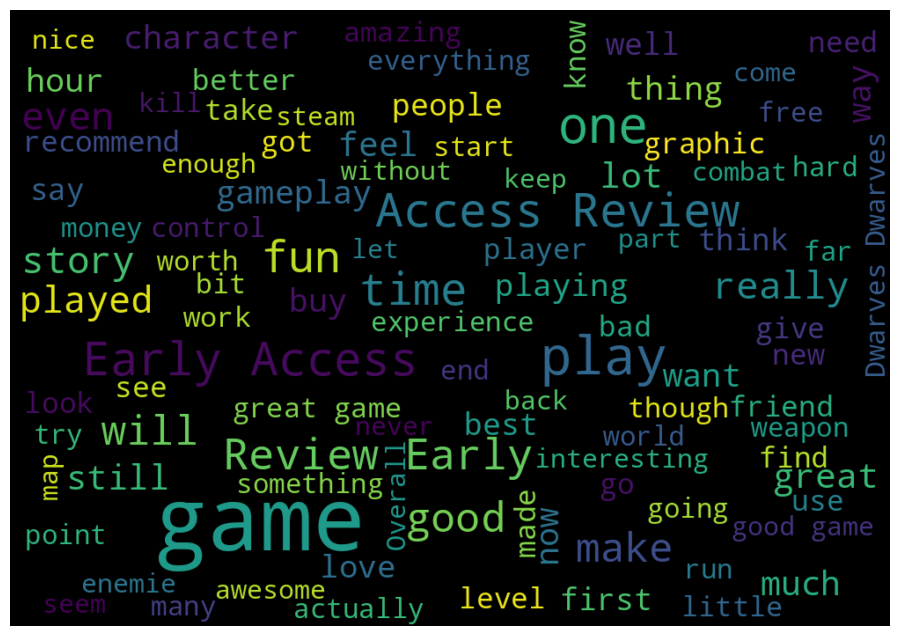

In [ ]:
txt = ' '.join(rev for rev in df_reviews_2.review_text )

plt.figure(figsize=(15, 8))

wordcloud = WordCloud(
    background_color='black',
    max_font_size=100,
    max_words=100,
    width=1000,
    height=700
).generate(txt)

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')

plt.show()

Ahora vamos a eliminar los comentarios que incluyen en el texto Early Access Review, porque son registros sin comentario alguno.

In [ ]:
df_reviews_2 = df_reviews_2[df_reviews_2.review_text != 'Early Access Review']


Ahora vamos a eliminar los registros que no tienen texto en el comentario

In [ ]:
df_reviews_2 = df_reviews_2[~df_reviews_2.review_text.isin(['nan'])]

Ahora vamos a eliminar registros que tengan valores iguales en `review_text` y `review_score`.

In [ ]:
df_reviews_2.drop_duplicates(['review_text', 'review_score' ], inplace = True )
#

print(df_reviews_2.shape)

(21179, 4)


In [ ]:
df_reviews_2.head()

,app_id,review_text,review_score,review_votes
0,10,Ruined my life.,1,0
1,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1
2,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0
3,10,Game will be played forever,1,0
4,10,i can't stop playing :D,1,0


**Observamos que hay un mensaje que tiene emojis, entonces queremos convertirlo a texto para poder hacer sentiment analysis**

In [ ]:
emoji_text= df_reviews['review_text'][1]

In [ ]:
emoji_text

"Think you got skills because you came from CS:GO?  Think you got skills cause you came from COD?  Think you got skills cause you just bought fallout 4 and still got money left on your steam account?   Well let me tell you a story.         You're going to suck ♥♥♥.       Alot of ♥♥♥."

In [ ]:
emoji.demojize(emoji_text)

"Think you got skills because you came from CS:GO?  Think you got skills cause you came from COD?  Think you got skills cause you just bought fallout 4 and still got money left on your steam account?   Well let me tell you a story.         You're going to suck :heart_suit::heart_suit::heart_suit:.       Alot of :heart_suit::heart_suit::heart_suit:."

# Función para convertir emojis a texto

In [ ]:
def emoji_totext(text):
    result = emoji.demojize(text)
    return result

In [ ]:
emoji_totext(emoji_text)

"Think you got skills because you came from CS:GO?  Think you got skills cause you came from COD?  Think you got skills cause you just bought fallout 4 and still got money left on your steam account?   Well let me tell you a story.         You're going to suck :heart_suit::heart_suit::heart_suit:.       Alot of :heart_suit::heart_suit::heart_suit:."

# Función para convertir corazones en asteriscos

In [ ]:
def replace_hearts_with_PAD(text):
    return re.sub(r"[♥]+", ' **** ' ,text)



**Si no se quiere trabajar con emojis tambien está la opción de eliminarlos**

## Función para remover emojis

In [ ]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticones
        u"\U0001F300-\U0001F5FF"  # simbolos y pictogramas
        u"\U0001F680-\U0001F6FF"  # transporte & simbolos de mapas
        u"\U0001F1E0-\U0001F1FF"  # banderas (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

## Función de limpieza de algunos carácteres básicos

In [ ]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

## Función para eliminar números

In [ ]:
def remove_num(text):
    output = re.sub(r'\d+', '', text )
    return output

##  Función para unificar espacios en blanco

In [ ]:
def unify_whitespaces(text):
    cleaned_string = re.sub(' +', ' ', text )
    return cleaned_string

## Función para eliminar puntuación

In [ ]:
def remove_punctuation(text):
    result = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',',') )
    return result

## Eliminar los stopwords


In [ ]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

stop = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemma = WordNetLemmatizer()

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop ]
    return ' '.join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Esta función unifica el texto en minúsculas.La función split crea una lista de palabras a partir del texto ingresado y verifica si hace parte de la lista de stopwords suministrada, si no hace parte de las stopwords se conserva dentro del texto. Al final la función join, vuelve y une las palabras que quedaron dejando un espacio de por medio.

## Función para usar stemming para normalizar las palabras

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('punkt')

def Stemming(text):
    stem = []
    stopword = stopwords.words('english')
    snowball_stemmer = SnowballStemmer('english')
    word_tokens = nltk.word_tokenize(text)
    stemmed_word = [ snowball_stemmer.stem(word) for word in word_tokens ]
    stem = ' '.join(stemmed_word)
    return stem

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Esta función toma un fragmento de texto, lo tokeniza en palabras, elimina las palabras vacías y, a continuación, aplica el stemmer Snowball. Luego, une las palabras en una sola cadena y la devuelve.

**Tokenización:**
La tokenización es el proceso de descomponer un texto en unidades más pequeñas, normalmente palabras o subpalabras, llamadas tokens. Estos tokens son los elementos básicos para el análisis posterior en tareas de PLN.

**Stemming:**
Es el proceso por el que se reducen las palabras a su raíz o forma base, llamada tallo. El objetivo principal es reducir las formas flexivas y a veces derivadas de una palabra a una forma base común. Esto ayuda en tareas como la normalización de textos y la recuperación de información, en las que distintas variaciones de las palabras pueden tener el mismo significado. Por ejemplo:
La palabra "running" se reduciría a "run".

## Aplicación de todos las funciones de limpieza

In [ ]:
def cleaning(df, review):
    df_processed = df.copy()
    df_processed[review] = df_processed['review_text']
    df_processed[review] = df_processed[review].apply(clean)
    #df_processed[review] = df_processed[review].apply(deEmojify)
    df_processed[review] = df_processed[review].apply(replace_hearts_with_PAD)
    df_processed[review] = df_processed[review].apply(remove_num)
    df_processed[review] = df_processed[review].apply(remove_punctuation)
    df_processed[review] = df_processed[review].apply(remove_stopwords)
    df_processed[review] = df_processed[review].apply(unify_whitespaces)
    df_processed[review] = df_processed[review].apply(Stemming)
    df_processed[review] = df_processed[review].apply(emoji_totext)
    return df_processed

df_processed = cleaning(df_reviews_2, 'review_text_clean' )

In [ ]:
df_processed.head()

,app_id,review_text,review_score,review_votes,review_text_clean
0,10,Ruined my life.,1,0,ruin life
1,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1,think got skill came csgo think got skill caus came cod think got skill caus bought fallout still got money left steam account well let tell stori go suck * * * * alot * * * *
2,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0,( i ve delet comment want give serious review game delet older one ya go ) older counter-strik peopl know peopl usual find enjoy play due either out-dat ' glitchi ' person tend enjoy game time time origin game made first sourc engin old school shooter general ai n't shabbi either due game small amount space fill comput rare ever lag make sure interrupt enjoy also competit present counter-strik...
3,10,Game will be played forever,1,0,game play forev
4,10,i can't stop playing :D,1,0,ca n't stop play
